IMDb Movie Review Dataset Source:
@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}

In [1]:
#dependencies
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import plot_roc_curve

In [8]:
#read review csv 
review_df=pd.read_csv('IMDB Dataset.csv')
review_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [9]:
#encode sentiment value into numeric sentiment
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label=le.fit(review_df['sentiment'])
label=label.transform(review_df["sentiment"])
label

array([1, 1, 1, ..., 0, 0, 0])

In [29]:
#split data into train and test
X_train,X_test,y_train,y_test=train_test_split(review_df['review'],label,random_state=42)

In [30]:
vector=TfidfVectorizer(stop_words='english',ngram_range=(1,2))
X_train = vector.fit_transform(X_train)
X_test=vector.transform(X_test)

In [31]:
def benchmark(clf):
    print('_'*80)
    print("Training: ")
    print(clf)
    t0=time()
    clf.fit(X_train,y_train)
    train_time=time()-t0
    print("train time: %0.3fs"% train_time)
    t0=time()
    pred=clf.predict(X_test)
    test_time=time()-t0
    print("test time :%0.3fs"%test_time)
    score=metrics.accuracy_score(y_test,pred)
    print("accuracy :   %0.3f"%score)
    clf_descr=str(clf).split('(')[0]
    try:
        roc_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
    except:
        print("error")
    return clf_descr,score,train_time,test_time

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 2.933s
test time :0.015s
accuracy :   0.908
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.452s
test time :0.011s
accuracy :   0.896
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                         

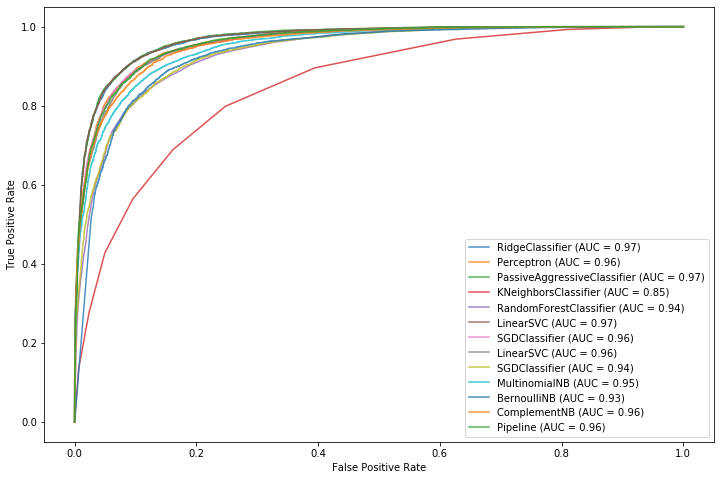

In [32]:
plt.figure(figsize=(12,8))
ax = plt.gca()
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10,n_jobs=-1), "kNN"),
        (RandomForestClassifier(n_jobs=-1), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))
print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))
plt.savefig("roc_curve")

In [33]:
indices = np.arange(len(results))
for i in indices:
    print(results[i])

('RidgeClassifier', 0.90752, 2.933285713195801, 0.015469551086425781)
('Perceptron', 0.89616, 0.4518721103668213, 0.010971546173095703)
('PassiveAggressiveClassifier', 0.9072, 0.6380727291107178, 0.01196742057800293)
('KNeighborsClassifier', 0.76264, 0.050786495208740234, 26.185646533966064)
('RandomForestClassifier', 0.86016, 392.8272171020508, 3.471675157546997)
('LinearSVC', 0.90688, 7.45876145362854, 0.01695561408996582)
('SGDClassifier', 0.89432, 0.9288897514343262, 0.011963605880737305)
('LinearSVC', 0.89312, 3.6810543537139893, 0.012967586517333984)
('SGDClassifier', 0.8624, 1.2736916542053223, 0.009957551956176758)
('MultinomialNB', 0.87696, 0.24664640426635742, 0.04552602767944336)
('BernoulliNB', 0.86048, 0.2881593704223633, 0.1788027286529541)
('ComplementNB', 0.886, 0.23940181732177734, 0.048877716064453125)
('Pipeline', 0.89592, 4.2885966300964355, 0.05884361267089844)


In [34]:
results=[[x[i] for x in results] for i in range(4)]

clf_names, score, training_time,test_time = results

In [35]:
training_time = np.array(training_time)/np.max(training_time)
test_time=np.array(test_time)/np.max(test_time)

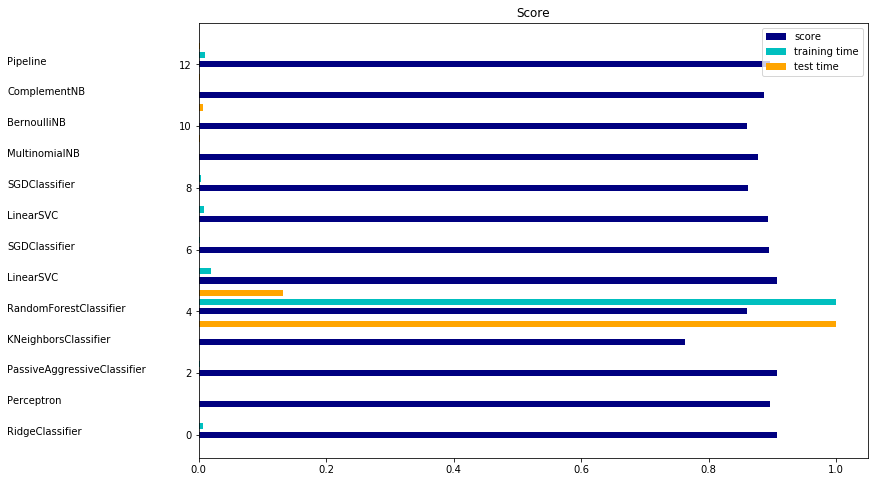

In [48]:
#plot of score of differnet models
plt.figure(figsize=(12,8))
ax=plt.subplot()
plt.title("Score")
plt.barh(indices,score,.2,label='score',color="navy")
plt.barh(indices+.3,training_time,.2,label="training time",color='c')
plt.barh(indices+.6,test_time,.2,label='test time',color='orange')
plt.legend(loc='best')

for i, c in zip(indices,clf_names):
    plt.text(-.3,i,c)
plt.savefig("score_plot")

In [49]:
clf=RidgeClassifier(tol=1e-2, solver="auto")

In [50]:
clf.fit(X_train,y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)

In [51]:
pred=clf.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.90752

In [52]:
params={'alpha':[0.1,0.3,0.5,0.7,1.0],
       'class_weight':[None,"balanced"],
       'tol':[1e-1,1e-2,1e-3]}

In [53]:
grid = GridSearchCV(clf, params, verbose=3,n_jobs=-1)

In [54]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=None, solver='auto',
                                       tol=0.01),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.3, 0.5, 0.7, 1.0],
                         'class_weight': [None, 'balanced'],
                         'tol': [0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [55]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.3, 'class_weight': None, 'tol': 0.01}
0.9021333333333335


In [56]:
pred=grid.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.9076

In [57]:
clf=SGDClassifier(alpha=.0001, max_iter=1000,penalty='l2')

In [58]:
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
pred=clf.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.89432

In [60]:
params={
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
}

In [61]:
grid = GridSearchCV(clf, params, verbose=3,n_jobs=-1)

In [62]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.8s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
        

In [63]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.0001}
0.8880800000000001


In [64]:
pred=grid.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.89424

In [86]:
clf=LinearSVC(penalty='l2', dual=False,tol=1e-3)

In [87]:
clf.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)

In [89]:
pred=clf.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.90688

In [88]:
params={'C': [1, 5, 10, 50],
       'dual':[True,False]}

In [90]:
grid=GridSearchCV(clf, params, verbose=3,n_jobs=-1)

In [91]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 5, 10, 50], 'dual': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [92]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 50, 'dual': True}
0.9033599999999999


In [93]:
pred=grid.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.90784

In [99]:
print(metrics.classification_report(y_test, pred, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.89      0.91      6157
    Positive       0.90      0.92      0.91      6343

    accuracy                           0.91     12500
   macro avg       0.91      0.91      0.91     12500
weighted avg       0.91      0.91      0.91     12500



In [94]:
from joblib import dump,load
dump(grid,"LinearSVC_grid.joblib")

['LinearSVC_grid.joblib']

In [78]:
clf=PassiveAggressiveClassifier()

In [79]:
clf.fit(X_train,y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

In [80]:
params={'C':[0.1,0.5,1,5,10,50]}

In [81]:
grid=GridSearchCV(clf, params, verbose=3,n_jobs=-1)

In [83]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:    9.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50]},
      

In [84]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1}
0.9037599999999999


In [85]:
pred=grid.predict(X_test)
metrics.accuracy_score(y_test,pred)

0.90744